In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from datahandling import BcomMEG

In [2]:
dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
epo_files = []
subjects = ['BCOM_18_2', 'BCOM_18_3', 'BCOM_18_4']
avoid_reading = True
data = BcomMEG(dir=dir, subjects=subjects, avoid_reading=avoid_reading)

Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_re_144-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_i_116-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Reading /Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT/BCOM_18_2_a_112-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
16 matching events found
No baseline correct

In [138]:
data.data

{'BCOM_18_2': {'re_144': <EpochsFIF | 8 events (all good), -0.3 – 0.5 s (baseline off), ~4.0 MB, data loaded,
   '144': 8>,
  'i_116': <EpochsFIF | 12 events (all good), -0.3 – 0.5 s (baseline off), ~5.8 MB, data loaded,
   '116': 12>,
  'a_112': <EpochsFIF | 16 events (all good), -0.3 – 0.5 s (baseline off), ~7.6 MB, data loaded,
   '112': 16>,
  'ri_146': <EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
   '146': 13>,
  'sa_152': <EpochsFIF | 13 events (all good), -0.3 – 0.5 s (baseline off), ~6.3 MB, data loaded,
   '152': 13>,
  'ma_132': <EpochsFIF | 18 events (all good), -0.3 – 0.5 s (baseline off), ~8.5 MB, data loaded,
   '132': 18>,
  'ra_142': <EpochsFIF | 14 events (all good), -0.3 – 0.5 s (baseline off), ~6.7 MB, data loaded,
   '142': 14>,
  'te_164': <EpochsFIF | 10 events (all good), -0.3 – 0.5 s (baseline off), ~4.9 MB, data loaded,
   '164': 10>,
  'si_156': <EpochsFIF | 6 events (all good), -0.3 – 0.5 s (baseline off), ~3.1 MB, dat

In [3]:
# first, sepreate out the conditions
a_labels = [a for a in data.data['BCOM_18_2'].keys() if 'a' in a]
e_labels = [e for e in data.data['BCOM_18_2'].keys() if 'e' in e]
i_labels = [i for i in data.data['BCOM_18_2'].keys() if 'i' in i]

for subject in data.data:
    a_epochs = mne.concatenate_epochs([data.data[subject][a] for a in a_labels])
    e_epochs = mne.concatenate_epochs([data.data[subject][e] for e in e_labels])
    i_epochs = mne.concatenate_epochs([data.data[subject][i] for i in i_labels])    


Not setting metadata
90 matching events found
No baseline correction applied
Not setting metadata
54 matching events found
No baseline correction applied
Not setting metadata
62 matching events found
No baseline correction applied
Not setting metadata
70 matching events found
No baseline correction applied
Not setting metadata
63 matching events found
No baseline correction applied
Not setting metadata
72 matching events found
No baseline correction applied
Not setting metadata
58 matching events found
No baseline correction applied
Not setting metadata
56 matching events found
No baseline correction applied
Not setting metadata
77 matching events found
No baseline correction applied


In [52]:
from mne.stats import permutation_cluster_test

permuataion_collection = [a_epochs.get_data(), e_epochs.get_data(), i_epochs.get_data()]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(permuataion_collection, n_permutations=2000, tail=0)

Using a threshold of 3.043980
stat_fun(H1): min=2.5895308760466117e-05 max=9.295301215841619
Running initial clustering …
Found 677 clusters


/var/folders/f1/tvmmnqs17399g3n7wyy0pq0c0000gn/T/ipykernel_80135/2382917169.py:4: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(permuataion_collection, n_permutations=2000, tail=0)


  0%|          | Permuting : 0/1999 [00:00<?,       ?it/s]

In [131]:
significant_sensors = np.where(cluster_p_values < 0.05)[0]

In [132]:
significant_sensors

array([], dtype=int64)

### 10 Best sensors based on mutual information

In [4]:
from sklearn.feature_selection import mutual_info_classif

num_a = len(a_epochs)
num_e = len(e_epochs)
num_i = len(i_epochs)
min_trials = (min(num_a, num_e, num_i))

a_rand = a_epochs[np.random.choice(num_a, min(num_a, num_e, num_i), replace=False)]
e_rand = e_epochs[np.random.choice(num_e, min(num_a, num_e, num_i), replace=False)]
i_rand = i_epochs[np.random.choice(num_i, min(num_a, num_e, num_i), replace=False)]

a_data = a_rand.get_data()
e_data = e_rand.get_data()
i_data = i_rand.get_data()

a_flat = a_data.reshape(a_data.shape[0], -1)
e_flat = e_data.reshape(e_data.shape[0], -1)
i_flat = i_data.reshape(i_data.shape[0], -1)


X = np.vstack([a_flat, e_flat, i_flat])
y = np.concatenate([np.ones(min_trials), np.ones(min_trials)*2, np.ones(min_trials)*3])
mi_scores = mutual_info_classif(X, y, random_state=0)
important_sensors = np.argsort(mi_scores)[-10:]



In [5]:
mi_reshaped = mi_scores.reshape(a_data.shape[1], a_data.shape[2])
sensor_mi_scores_reshaped = mi_reshaped.mean(axis=1)
important_sensors = np.argsort(sensor_mi_scores_reshaped)[-10:]
sensor_names = a_epochs.info['ch_names']
important_sensor_names = [sensor_names[i] for i in important_sensors]
print(important_sensor_names)
sensor_mi_scores_reshaped[important_sensors]


['MEG 082', 'MEG 218', 'MEG 050', 'MEG 244', 'MEG 102', 'MEG 179', 'MEG 089', 'MEG 079', 'MEG 239', 'MEG 161']


array([0.02107198, 0.02129063, 0.02130819, 0.02138437, 0.02167318,
       0.02180544, 0.02199735, 0.02215351, 0.02251529, 0.02437352])

(<matplotlib.image.AxesImage at 0x35e7fd220>, None)

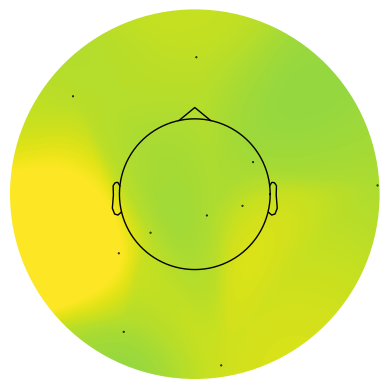

In [43]:
import mne.channels


important_sensor_names
sensor_mi_scores_reshaped[important_sensors]

info = a_epochs.info
picks = mne.pick_channels(info['ch_names'], include=important_sensor_names)

pos = mne.channels.layout._find_topomap_coords(info, picks)

data = np.array(sensor_mi_scores_reshaped[important_sensors])

fig, ax = plt.subplots()
mne.viz.plot_topomap(data, pos, axes=ax, show=False, cmap='viridis', contours=0)

## Ok so where in the brain?

In [ ]:
import os
subject_dir = os.path.expanduser('~/mne_data/MNE-fsaverage-data')
bem_dir = os.path.expanduser('~/mne_data/MNE-fsaverage-data/')
# head transformation, need to use average because no MRIs
transformation = 'fsaverage'

# standard source space and BEM model - "Boundary Element Method" model. i.e., a realistic head model to use for source localization. 
# apparently it deifnes the el

src = mne.setup_source_space(subject='fsaverage', spacing='oct6', subjects_dir=subject_dir) # 5 mins

bem = mne.make_bem_model(subject='fsaverage', subjects_dir=bem_dir) 

bem = mne.make_bem_solution(bem)

# only for the chosen sensors

picks = mne.pick_channels(info['ch_names'], include=important_sensor_names)

# forward model

fwd = mne.make_forward_solution(info=a_epochs.info, trans=transformation, src=src, bem=bem, eeg=False)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'fsaverage', ~35.0 MB>
MRI -> head transform : /opt/homebrew/Caskroom/miniconda/base/envs/mne/lib/python3.12/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read 247 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.994570 -0.096133 -0.039854      -2.40 mm
    0.101937 0.977019 0.187196     -35.72 m

In [79]:
# get it for only certain channels

picks = mne.pick_channels(fwd['info']['ch_names'], include=important_sensor_names[0:2])
fwd_selected = mne.pick_channels_forward(fwd, include=important_sensor_names[0:1])

    1 out of 247 channels remain after picking


In [80]:
# Computing the inverse model:

noise_cov = mne.compute_covariance(a_epochs, method='auto')

# create an inverse operator to convert signals to brain activity

inv = mne.minimum_norm.make_inverse_operator(info=a_epochs.info, forward=fwd_selected, noise_cov=noise_cov)

Reducing data rank from 247 -> 247
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    MAG regularization : 0.1
    MAG regularization : 0.1
Number of samples used : 13978
log-likelihood on unseen data (descending order):
   shrunk: -1370.522
   empirical: -1371.440
   diagonal_fixed: -1427.383
selecting best estimator: shrunk
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 1 channels.
    1 out of 1 channels remain after picking
Selected 1 channels
Creating the depth weighting matrix...
    1 magnetometer or axial gradiometer channels
    limit = 5676/8196 = 10.002849
    scale = 5.59918e-12

In [81]:
# computing source esitmation

lambda2 = 1.0 / 9.0 # regularization parameter
method = "dSPM" # or "dSPM"

stc = mne.minimum_norm.apply_inverse(a_epochs.average(), inv, lambda2, method)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 58
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 1 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "0.09 × 112 + 0.07 × 152 + 0.22 × 132 + 0.22 × 142 + 0.22 × 162 + 0.17 × 122"...
    Picked 1 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  99.0% variance
    Combining the current components...
    dSPM...
[done]


In [82]:
brain = stc.plot(hemi='split', subjects_dir=subject_dir, subject='fsaverage', time_viewer=True)

Using control points [3.26156745 3.43162634 4.04986332]


qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x17bd27a50> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x3d2827b40> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160490780> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160491b10> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160496630> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x160497860> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1 doesn't match <NSViewBackingLayer: 0x1604981b0> contents scale of 2 - updating layer to match.
qt.qpa.backingstore: Back buffer dpr of 1

In [39]:
peak_vertex, peak_time = stc.get_peak()
print(f"Peak activation at vertex {peak_vertex} at {peak_time} seconds")

Peak activation at vertex 86178 at 0.21666666666666673 seconds
